# distance comparison of RoBERTa model trained with Tox

2020/11/24

in this version, we set the number of epoch into 3 and pretrain the test datasets in the linear layers.

In [1]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup

In [2]:
# Initialize tokenizer.
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [3]:
source_folder = 'Data'
destination_folder = 'Model'

In [4]:
import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

# Set random seed and set device to GPU.
torch.manual_seed(17)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

print(device)

cuda:0


In [5]:
# Model parameter
MAX_SEQ_LEN = 128
BATCH_SIZE = 8
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)
fields = [('comment', text_field),('toxicity', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='Train_comment_toxity.csv', validation='Val_comment_toxity.csv',
                                           test='Test_comment_toxity.csv', format='CSV', fields=fields, skip_header=True)


train_iter_toxity = BucketIterator(train, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.comment),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter_toxity = BucketIterator(valid, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.comment),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter_toxity = Iterator(train, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [6]:
def embedding_on_GAB(test_file, text_name,label_name):
    # Model parameter
    MAX_SEQ_LEN = 128
    # Set tokenizer hyperparameters.
    BATCH_SIZE = 8
    PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
    UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)


    # Define columns to read.
    label_field = Field(sequential=False, use_vocab=False, batch_first=True)
    text_field = Field(use_vocab=False, 
                       tokenize=tokenizer.encode, 
                       include_lengths=False, 
                       batch_first=True,
                       fix_length=MAX_SEQ_LEN, 
                       pad_token=PAD_INDEX, 
                       unk_token=UNK_INDEX)

    fields = [(text_name, text_field),(label_name, label_field)]


    # TabularDataset

    train, valid, test = TabularDataset.splits(path=source_folder,train=test_file, validation=test_file,
                                               test=test_file, format='CSV', fields=fields, skip_header=True)


    train_iter = BucketIterator(train, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.Text),
                                device=device, train=True, sort=True, sort_within_batch=True)
    valid_iter = BucketIterator(valid, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.Text),
                                device=device, train=True, sort=True, sort_within_batch=True)
    test_iter = Iterator(test, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)
 
    return train_iter, valid_iter, test_iter

In [7]:
Text_field = 'Text'
label_field = 'Hate'
file_field = "final_GAB.csv"
train_iter_GAB, valid_iter_GAB, GAB_embedding = embedding_on_GAB(file_field,Text_field ,label_field)

In [8]:
# Functions for saving and loading model parameters and metrics.
def save_checkpoint(path, model, valid_loss):
    torch.save({'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}, path)

    
def load_checkpoint(path, model):    
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(path, train_loss_list, valid_loss_list, global_steps_list):   
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, path)


def load_metrics(path):    
    state_dict = torch.load(path, map_location=device)
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [9]:
# Model with extra layers on top of RoBERTa
class ROBERTAClassifier(torch.nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ROBERTAClassifier, self).__init__()
        
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 64)
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(64, 2)
        
    def forward(self, input_ids, attention_mask):
        _, x = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        x1 = self.d1(x)
        x2 = self.l1(x1)
        x3 = self.bn1(x2)
        x4 = torch.nn.Tanh()(x3)
        x5 = self.d2(x4)
        x6 = self.l2(x5)
        
        return x6

In [10]:
output_path = 'Model_roberta'
model = ROBERTAClassifier()
model = model.to(device)

load_checkpoint(output_path + '/model.pkl', model)

0.08750647318014222

In [11]:
def Finetuning(model, 
             optimizer, 
             train_iter, 
             valid_iter,
             valid_period,
             scheduler = None,
             num_epochs = 5):
    PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
    # Pretrain linear layers, do not train bert
    for param in model.roberta.parameters():
        param.requires_grad = False
    
    
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0   
    global_step = 0  
    # Train loop
    for epoch in range(num_epochs):
        count = 0
        for (source, target), _ in train_iter:
            mask = (source != PAD_INDEX).type(torch.uint8)
        
            y_pred = model(input_ids=source,  
                           attention_mask=mask)

            loss = torch.nn.CrossEntropyLoss()(y_pred, target)
#             print('batch_no [{}/{}]:'.format(count, int(len(train_iter))),'training_loss:',loss)
            count+=1
            loss.backward()
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for (source, target), _ in valid_iter:
                        mask = (source != PAD_INDEX).type(torch.uint8)
                        
                        y_pred = model(input_ids=source, 
                                       attention_mask=mask)
                        
                        loss = torch.nn.CrossEntropyLoss()(y_pred, target)
                        
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                
                model.train()

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], PT Loss: {:.4f}, Val Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
    print('finetuning done!')
    return model

# Toxicity

In [12]:
NUM_EPOCHS = 3
steps_per_epoch = len(train_iter_toxity)
optimizer = AdamW(model.parameters(), lr=1e-5)
scheduler = get_linear_sche
dule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*1, 
                                          num_training_steps=steps_per_epoch*NUM_EPOCHS)
print("======================= Start finetuning ==============================")
model_fintuned_Toxity = Finetuning(model=model,
         train_iter=train_iter_toxity, 
         valid_iter=valid_iter_toxity,
         valid_period=len(train_iter_toxity),
         optimizer=optimizer,
         scheduler=scheduler,
         num_epochs=NUM_EPOCHS)

======================= Start finetuning ==============================
Epoch [1/3], global step [11962/35886], PT Loss: 0.0702, Val Loss: 0.0835
Epoch [2/3], global step [23924/35886], PT Loss: 0.0742, Val Loss: 0.0862
Epoch [3/3], global step [35886/35886], PT Loss: 0.0747, Val Loss: 0.0880
finetuning done!


In [13]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
# Evaluation Function
import seaborn as sns
def generate(model, test_loader):
    y_pred = []
    y_prob = []
    model.eval()
    with torch.no_grad():
        for (source, target), _ in tqdm(test_loader):
                mask = (source != PAD_INDEX).type(torch.uint8)
                output = model(source, attention_mask=mask)
                y_prob.extend(output.tolist())
    return y_prob

In [14]:
from tqdm import tqdm
prediction_list = generate(model_fintuned_Toxity , test_iter_toxity)

100%|████████████████████████████████████████████████████████████████████████████| 11962/11962 [10:44<00:00, 18.57it/s]


In [15]:
x_Toxity = [item[0] for item in prediction_list]
y_Toxity = [item[1] for item in prediction_list]

In [16]:
prediction_list[0:8]

[[3.7411837577819824, -3.067441463470459],
 [3.404839515686035, -2.805044174194336],
 [3.4881975650787354, -2.8845345973968506],
 [2.735128164291382, -2.3303143978118896],
 [3.252864122390747, -2.6985859870910645],
 [3.613381862640381, -2.9664466381073],
 [3.534959554672241, -2.9196724891662598],
 [2.7418136596679688, -2.3194215297698975]]

In [17]:
from tqdm import tqdm
final_point = []
for item in tqdm(prediction_list):
       final_point.append(sum(item))

100%|███████████████████████████████████████████████████████████████████████| 95692/95692 [00:00<00:00, 1453760.03it/s]


In [18]:
import pandas as pd
toxity = pd.read_csv('Data/Train_comment_toxity.csv',sep = ',')

In [19]:
toxity.head()

,comment,toxicity
0,this one can make an analogy in mathematical t...,0
1,clarification for you and zundark s right i...,0
2,this is such a fun entry devotchka i once had...,0
3,i fixed the link i also removed homeopathy ...,0
4,if they are indisputable then why does the ...,0


In [20]:
length_toxity = []
for sentence in tqdm(toxity['comment']):
    length_toxity.append(len(sentence.split()))

100%|████████████████████████████████████████████████████████████████████████| 95692/95692 [00:00<00:00, 208583.26it/s]


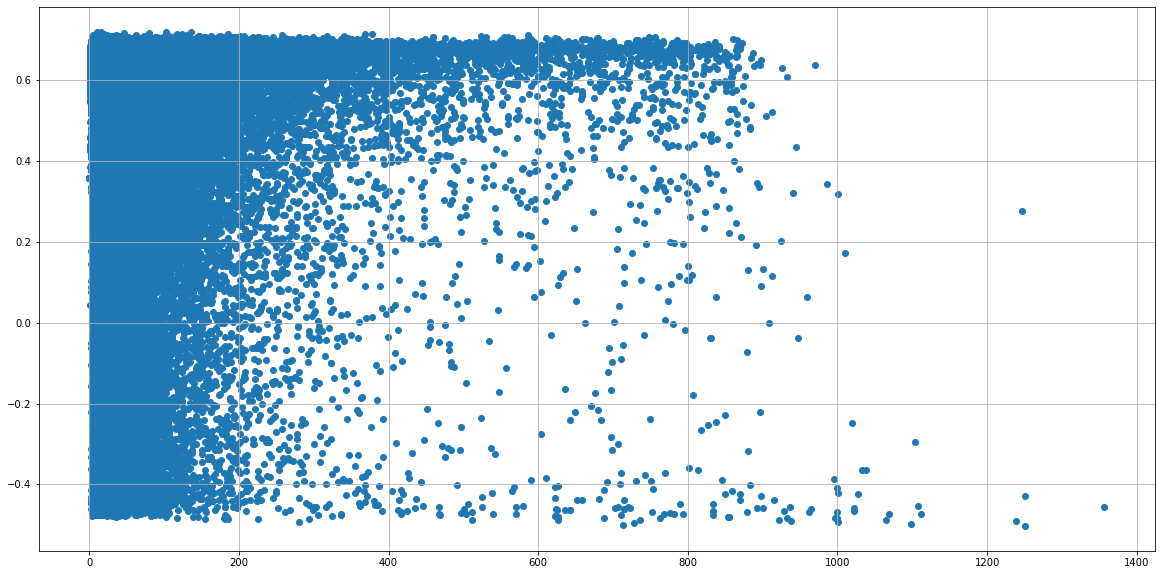

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.scatter(length_toxity, final_point)
plt.grid()
plt.show()

# GAB

In [22]:
NUM_EPOCHS = 3
steps_per_epoch = len(train_iter_GAB)
optimizer = AdamW(model.parameters(), lr=1e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*1, 
                                          num_training_steps=steps_per_epoch*NUM_EPOCHS)



print("======================= Start finetuning ==============================")
model_fintuned_GAB = Finetuning(model=model,
         train_iter=train_iter_GAB, 
         valid_iter=valid_iter_GAB,
         valid_period=len(train_iter_GAB),
         optimizer=optimizer,
         scheduler=scheduler,
         num_epochs=NUM_EPOCHS)

======================= Start finetuning ==============================
Epoch [1/3], global step [3459/10377], PT Loss: 0.4958, Val Loss: 0.3496
Epoch [2/3], global step [6918/10377], PT Loss: 0.3220, Val Loss: 0.3061
Epoch [3/3], global step [10377/10377], PT Loss: 0.3064, Val Loss: 0.3015
finetuning done!


In [23]:
prediction_list_GAB = generate(model_fintuned_GAB , GAB_embedding)

100%|██████████████████████████████████████████████████████████████████████████████| 3459/3459 [03:06<00:00, 18.57it/s]


In [24]:
x_GAB = [item[0] for item in prediction_list_GAB]
y_GAB = [-item[1] for item in prediction_list_GAB]

In [25]:
from tqdm import tqdm
final_point_GAB = []
for item in tqdm(prediction_list_GAB):
       final_point_GAB.append(sum(item))

100%|███████████████████████████████████████████████████████████████████████| 27665/27665 [00:00<00:00, 1459932.31it/s]


In [26]:
GAB_final = pd.read_csv("Data/final_GAB.csv",sep=',')

In [27]:
GAB_final.head()

,Text,Hate,length
0,ah the psyops antifa crew is back that s how i...,0,15
1,get the new android app update released today ...,0,9
2,study google pushes liberal news in top 5 sear...,0,10
3,claiming bias against conservatives has filed...,1,17
4,these companies are run by sociopaths he said...,0,37


In [28]:
length_GAB = []
import numpy as np
for sentence in tqdm(GAB_final['Text']):
    if pd.isnull(sentence):
        length_GAB.append(0)
    else:
        length_GAB.append(len(sentence.split()))

100%|████████████████████████████████████████████████████████████████████████| 27665/27665 [00:00<00:00, 407931.92it/s]


In [29]:
prediction_list_GAB[0:8]

[[1.5225372314453125, -1.4830571413040161],
 [1.7190792560577393, -1.6272748708724976],
 [1.451416254043579, -1.4416985511779785],
 [1.4070836305618286, -1.403623104095459],
 [0.8262496590614319, -0.9741122722625732],
 [1.1728414297103882, -1.2371220588684082],
 [1.4621285200119019, -1.445031762123108],
 [1.203009843826294, -1.2635279893875122]]

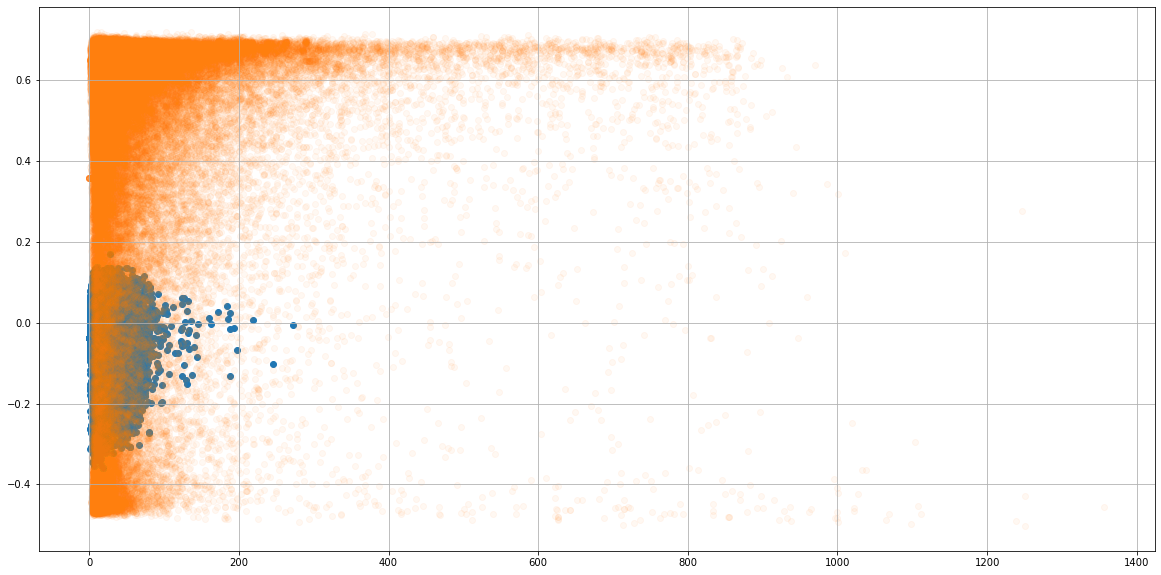

In [30]:
plt.figure(figsize=(20,10))
plt.scatter(length_GAB, final_point_GAB)
plt.scatter(length_toxity, final_point,alpha=0.05)
plt.grid()
plt.show()

# 2400 test

In [31]:
# Model parameter
MAX_SEQ_LEN = 128
BATCH_SIZE = 8
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)
fields = [('comment', text_field),('toxicity', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='test5.csv', validation='test5.csv',
                                           test='test5.csv', format='CSV', fields=fields, skip_header=True)


train_iter_2400 = BucketIterator(train, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.comment),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter_2400 = BucketIterator(valid, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.comment),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter_2400 = Iterator(train, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [32]:
NUM_EPOCHS = 3
steps_per_epoch = len(train_iter_GAB)
optimizer = AdamW(model.parameters(), lr=1e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*1, 
                                          num_training_steps=steps_per_epoch*NUM_EPOCHS)

print("======================= Start finetuning ==============================")
model_fintuned_2400 = Finetuning(model=model,
         train_iter=train_iter_2400, 
         valid_iter=valid_iter_2400,
         valid_period=len(train_iter_2400),
         optimizer=optimizer,
         scheduler=scheduler,
         num_epochs=NUM_EPOCHS)

======================= Start finetuning ==============================
Epoch [1/3], global step [290/870], PT Loss: 0.6254, Val Loss: 0.6202
Epoch [2/3], global step [580/870], PT Loss: 0.6427, Val Loss: 0.6035
Epoch [3/3], global step [870/870], PT Loss: 0.6063, Val Loss: 0.5821
finetuning done!


In [33]:
prediction_list_2400 = generate(model_fintuned_2400 , test_iter_2400)

100%|████████████████████████████████████████████████████████████████████████████████| 290/290 [00:15<00:00, 18.59it/s]


In [34]:
from tqdm import tqdm
final_point_2400 = []
for item in tqdm(prediction_list_2400):
       final_point_2400.append(sum(item))

100%|█████████████████████████████████████████████████████████████████████████| 2319/2319 [00:00<00:00, 1164442.83it/s]


In [35]:
t2400_final = pd.read_csv("Data/test5.csv",sep=',')

In [36]:
length_2400 = []
for sentence in tqdm(t2400_final['comment']):
    if pd.isnull(sentence):
        length_2400.append(0)
    else:
        length_2400.append(len(sentence.split()))

100%|██████████████████████████████████████████████████████████████████████████| 2319/2319 [00:00<00:00, 232498.89it/s]


# AC test

In [39]:
# Model parameter
MAX_SEQ_LEN = 128
BATCH_SIZE = 8
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)
fields = [('comment', text_field),('attack', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='Train_comment.csv', validation='Val_comment.csv',
                                           test='Train_comment.csv', format='CSV', fields=fields, skip_header=True)


train_iter_AC = BucketIterator(train, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.comment),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter_AC = BucketIterator(valid, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.comment),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter_AC = Iterator(train, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [40]:
NUM_EPOCHS = 3
steps_per_epoch = len(train_iter_AC)
optimizer = AdamW(model.parameters(), lr=1e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*1, 
                                          num_training_steps=steps_per_epoch*NUM_EPOCHS)

print("======================= Start finetuning ==============================")
model_fintuned_AC = Finetuning(model=model, train_iter=train_iter_AC , 
         valid_iter=valid_iter_AC,
         valid_period=len(train_iter_AC),
         optimizer=optimizer,
         scheduler=scheduler,
         num_epochs=NUM_EPOCHS)

======================= Start finetuning ==============================
Epoch [1/3], global step [8679/26037], PT Loss: 0.3228, Val Loss: 0.3027
Epoch [2/3], global step [17358/26037], PT Loss: 0.3054, Val Loss: 0.3018
Epoch [3/3], global step [26037/26037], PT Loss: 0.3050, Val Loss: 0.2951
finetuning done!


In [41]:
prediction_list_AC = generate(model_fintuned_AC , test_iter_AC)

100%|██████████████████████████████████████████████████████████████████████████████| 8679/8679 [06:51<00:00, 21.11it/s]


In [42]:
from tqdm import tqdm
final_point_AC = []
for item in tqdm(prediction_list_AC):
       final_point_AC.append(sum(item))

100%|███████████████████████████████████████████████████████████████████████| 69426/69426 [00:00<00:00, 1545417.51it/s]


In [43]:
AC_final = pd.read_csv("Data/Train_comment.csv",sep=',')

In [44]:
length_AC = []
for sentence in tqdm(AC_final['comment']):
    if pd.isnull(sentence):
        length_AC.append(0)
    else:
        length_AC.append(len(sentence.split()))

100%|████████████████████████████████████████████████████████████████████████| 69426/69426 [00:00<00:00, 180809.76it/s]


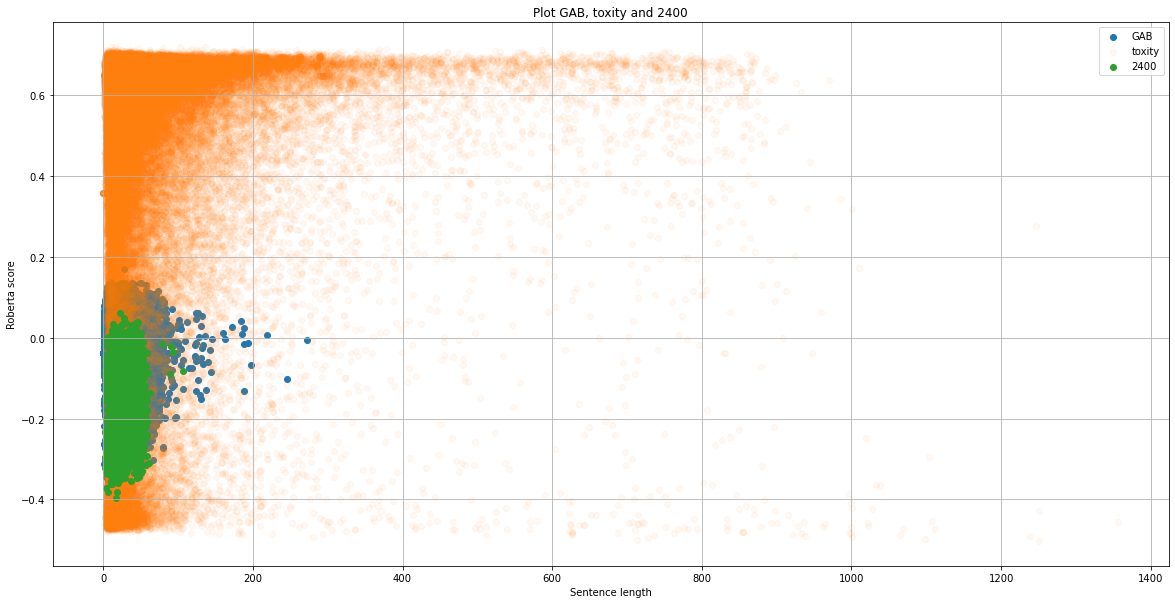

In [45]:
plt.figure(figsize=(20,10))
plt.scatter(length_GAB, final_point_GAB, label = 'GAB')
plt.scatter(length_toxity, final_point,alpha=0.05, label = 'toxity')
plt.scatter(length_2400, final_point_2400, label = '2400')
plt.title('Plot GAB, toxity and 2400')
plt.grid()
plt.ylabel('Roberta score')
plt.xlabel('Sentence length')
plt.legend()
plt.show()

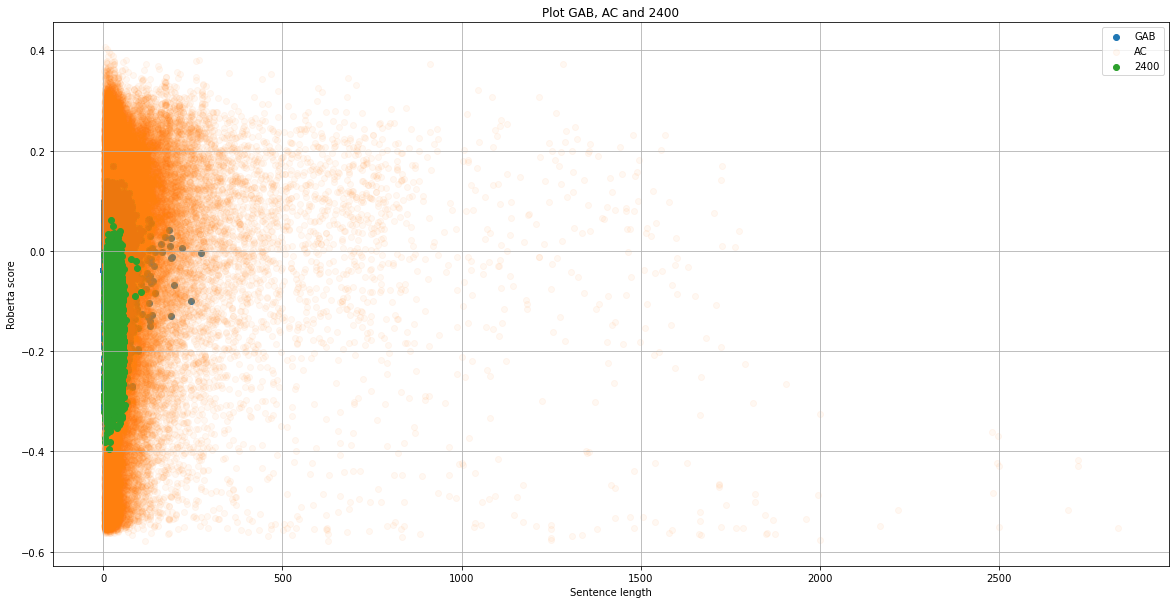

In [46]:
plt.figure(figsize=(20,10))
plt.scatter(length_GAB, final_point_GAB, label = 'GAB')
plt.scatter(length_AC, final_point_AC, label = 'AC', alpha= 0.05)
plt.scatter(length_2400, final_point_2400, label = '2400')
plt.grid()
plt.title('Plot GAB, AC and 2400')
plt.ylabel('Roberta score')
plt.xlabel('Sentence length')
plt.legend()
plt.show()

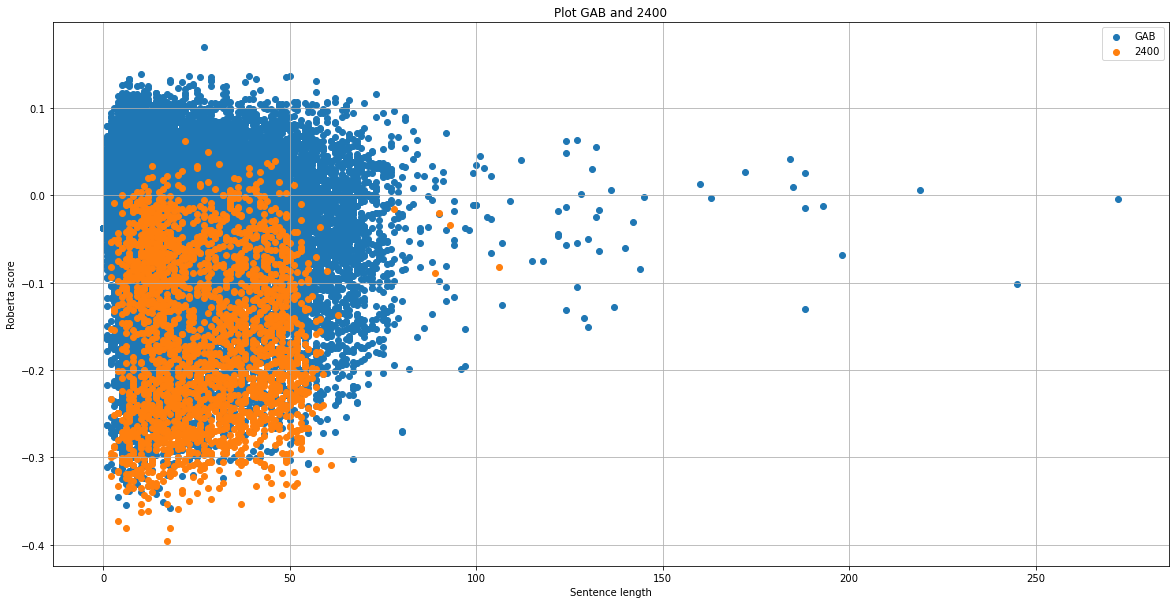

In [47]:
plt.figure(figsize=(20,10))
plt.scatter(length_GAB, final_point_GAB, label = 'GAB')
plt.scatter(length_2400, final_point_2400, label = '2400')
plt.grid()
plt.title('Plot GAB and 2400')
plt.ylabel('Roberta score')
plt.xlabel('Sentence length')
plt.legend()
plt.show()

In [51]:
final_point_GAB = [-i for i in final_point_GAB]
final_point = [-i for i in final_point]
final_point_AC = [-i for i in final_point_AC]
final_point_2400 = [-i for i in final_point_2400]

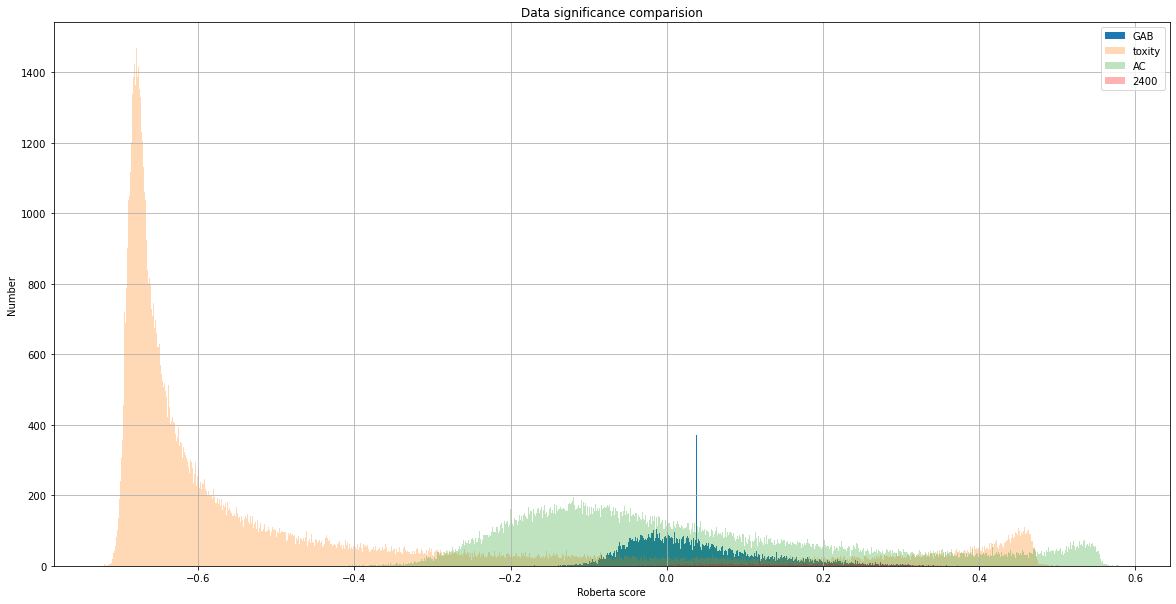

In [52]:
plt.figure(figsize=(20,10))
plt.hist(final_point_GAB, label= 'GAB', bins=1000)
plt.hist(final_point, label = 'toxity', bins = 1000,alpha = 0.3)
plt.hist(final_point_AC,label = 'AC', bins = 1000,alpha = 0.3)
plt.hist(final_point_2400, label = '2400', bins = 1000,color='r', alpha = 0.3)
plt.title('Data significance comparision')
plt.grid()
plt.ylabel('Number')
plt.xlabel('Roberta score')
plt.legend()
plt.show()

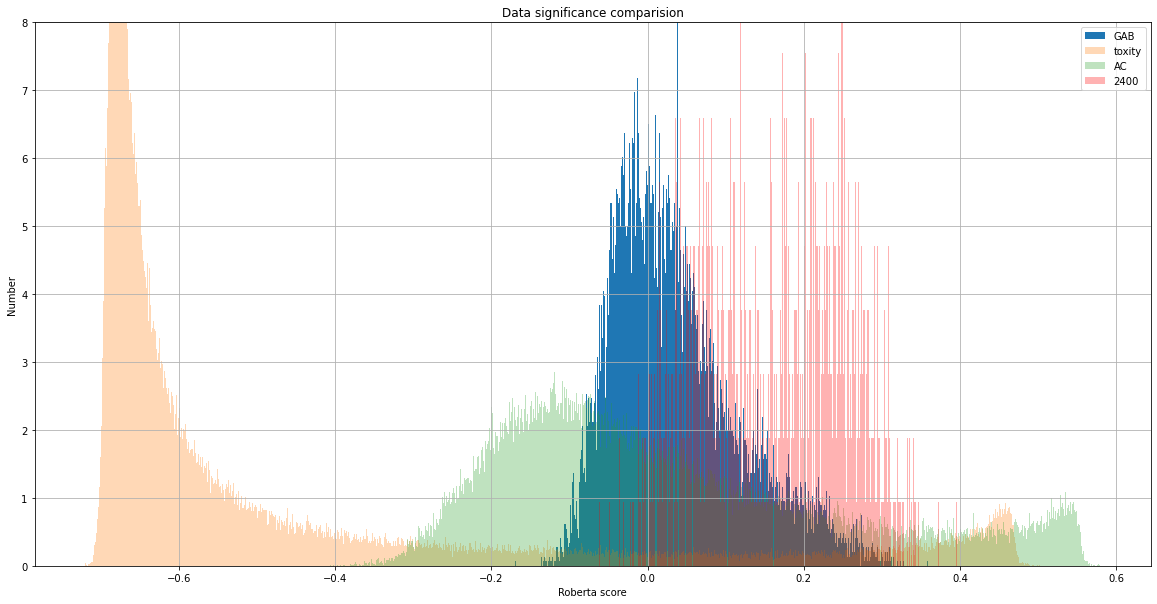

In [53]:
plt.figure(figsize=(20,10))
plt.hist(final_point_GAB, density = True, label= 'GAB', bins=1000)
plt.hist(final_point,density = True, label = 'toxity', bins = 1000,alpha = 0.3)
plt.hist(final_point_AC,label = 'AC', bins = 1000,alpha = 0.3,density = True)
plt.hist(final_point_2400, label = '2400', bins = 1000,color='r',density=True, alpha = 0.3)
plt.title('Data significance comparision')
plt.grid()
plt.ylim(0,8)
plt.ylabel('Number')
plt.xlabel('Roberta score')
plt.legend()
plt.show()